In [32]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [33]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [34]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [35]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [36]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

C:\Users\Rachel\AppData\Local\Temp\ipykernel_18868\4196587217.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [37]:
# We can view all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [38]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [39]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [40]:
# Find the most recent date in the data set.
results_date=session.query(Measurement.date).order_by(Measurement.date.desc()).first()
results_date

('2017-08-23',)

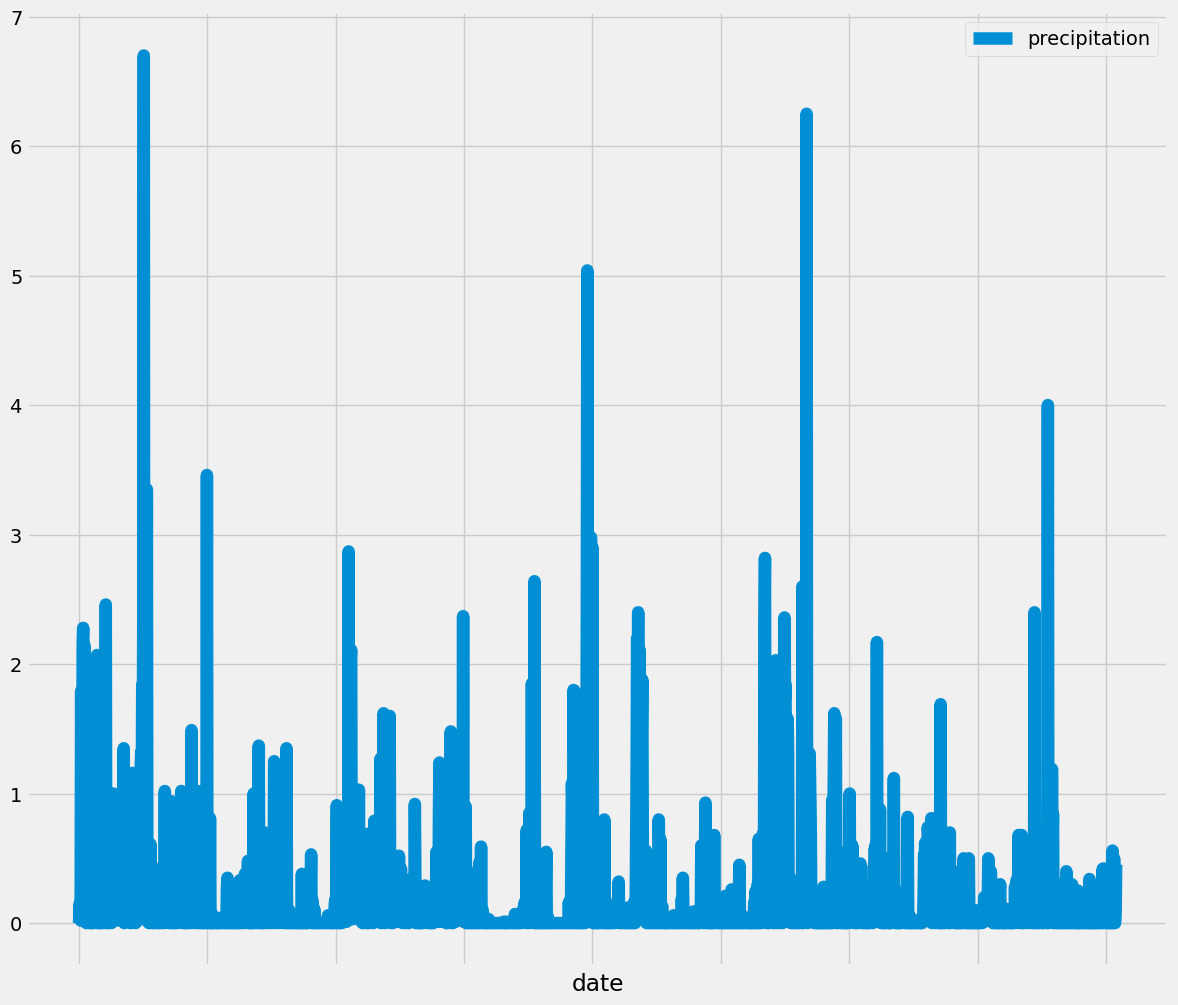

In [41]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
str_date=list(np.ravel(results_date))[0]
latest_date=dt.datetime.strptime(str_date,"%Y-%m-%d")
year_back=latest_date-dt.timedelta(days=366)
# Perform a query to retrieve the data and precipitation scores
results=session.query(Measurement.date, Measurement.prcp).order_by(Measurement.date.asc()).\
        filter(Measurement.date>=year_back).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df_results=pd.DataFrame(results)
df_results=df_results.rename(columns={"prcp":"precipitation"})
# Sort the dataframe by date
df_results.sort_values(by=['date'], ascending=True)
df_results=df_results.dropna()
df_results=df_results.reset_index(drop=True)

# Use Pandas Plotting with Matplotlib to plot the data
ax=df_results.plot(figsize=(12,10),legend=True,linewidth=9.0,grid=True)
#Removing xticks
plt.setp(ax.get_xticklabels(), visible=False)
plt.tight_layout()
plt.xlabel("date")
plt.show()

In [42]:
# Use Pandas to calculate the summary statistics for the precipitation data
df_results.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [43]:
# Design a query to calculate the total number of stations in the dataset
station_count=session.query(func.count(Station.id)).all()
station_count

[(9,)]

In [52]:
print(f"There are {station_count[0][0]} stations in the dataset.")

There are 9 stations in the dataset.


In [44]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

station_Measurment_join=session.query(Measurement.station,func.count(Measurement.station)).\
                       group_by(Measurement.station).\
                       order_by(func.count(Measurement.station).desc()).all()
station_Measurment_join

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [53]:
# Which station id has the greatest number of observations?
most_active_station = station_Measurment_join[0][0]

# Show the most active station
print(f"{most_active_station} has the greatest number of observations.")

USC00519281 has the greatest number of observations.


In [55]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

results_temp=session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
             filter(Measurement.station==station_Measurment_join[0][0]).all()
results_temp

[(54.0, 85.0, 71.66378066378067)]

In [56]:
# Show the temperature values
print(f"The lowest temperature at {most_active_station} is {results_temp[0][0]} Fahrenheit.")
print(f"The highest temperature at {most_active_station} is {results_temp[0][1]} Fahrenheit.")
print(f"The average temperature at {most_active_station} is {round(results_temp[0][2], 3)} Fahrenheit.")

The lowest temperature at USC00519281 is 54.0 Fahrenheit.
The highest temperature at USC00519281 is 85.0 Fahrenheit.
The average temperature at USC00519281 is 71.664 Fahrenheit.


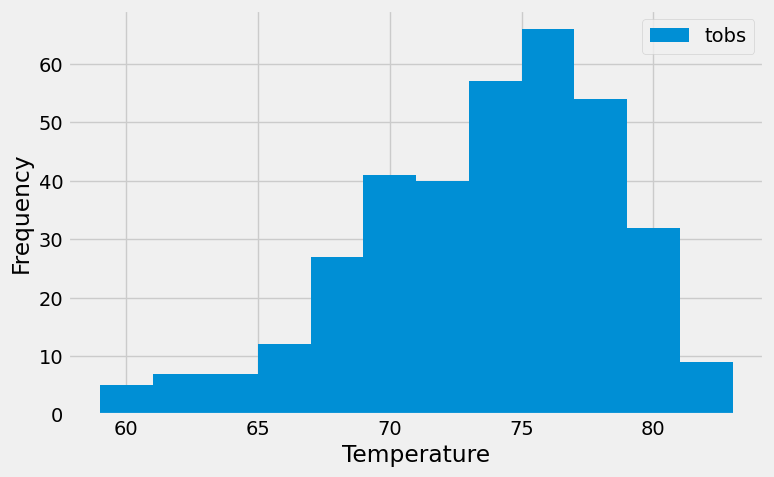

In [46]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results_date=session.query(Measurement.date).order_by(Measurement.date.desc()).\
             filter(Measurement.station==station_Measurment_join[0][0]).first()
str_date=list(np.ravel(results_date))[0]
latest_date=dt.datetime.strptime(str_date,"%Y-%m-%d")
year_back=latest_date-dt.timedelta(days=366)

results_temp=session.query(Measurement.tobs).\
             filter(Measurement.station==station_Measurment_join[0][0]).\
             filter(Measurement.date>=year_back).all()
df_results=pd.DataFrame(results_temp)

#Plotting Histogram
hist = df_results['tobs'].hist(bins=12,figsize=(8,5), zorder=2, label='tobs')

# Set x-axis label
hist.set_xlabel("Temperature")

# Set y-axis label
hist.set_ylabel("Frequency")
plt.legend()
plt.show()

# Close Session

In [47]:
# Close Session
session.close()